# 2. Introduction to msprime

1. Why use msprime?
2. Getting started
3. Recombination
4. Mutation
5. Population structure
6. Demographic events
7. Large simulations
8. Exporting to other data formats

## 2.1 Why use msprime?

 - Why use `msprime`?
 - Simulations - why are they important?
 - What are some features that good simulations should have?

## 2.2 Getting started

### Importing msprime

In [1]:
import msprime
from IPython.display import SVG

### A simple simulation

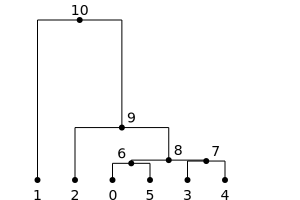

In [2]:
ts = msprime.simulate(sample_size = 6)

for tree in ts.trees():
    display(SVG(tree.draw(width=300)))

Only a single tree because no recombination as yet.

In trees generated by msprime, times are recorded in units of generations.

Note non-integer times - this is a feature of coalescent model.

### Random seeds

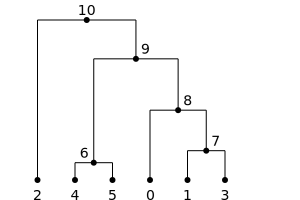

In [3]:
ts = msprime.simulate(sample_size = 6, random_seed = 10)

for tree in ts.trees():
    display(SVG(tree.draw(width=300)))

## 2.3 Recombination

Tree on interval (0.0, 181.74732201307717)


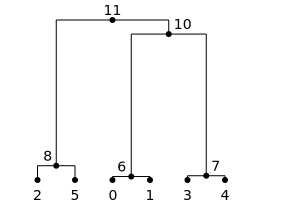

Tree on interval (181.74732201307717, 1000.0)


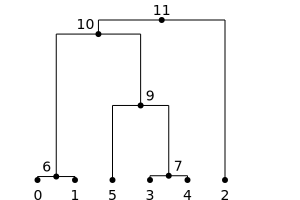

In [4]:
ts = msprime.simulate(sample_size = 6, random_seed = 12,
                     length = 1000, recombination_rate = 1e-4 )

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

## 2.4 Mutation

Tree on interval (0.0, 181.74732201307717)


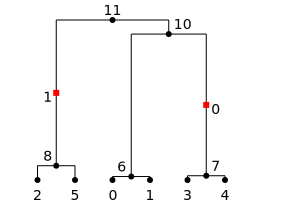

Tree on interval (181.74732201307717, 1000.0)


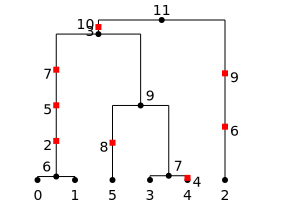

In [5]:
ts = msprime.simulate(sample_size = 6, random_seed = 12,
                     length = 1000, recombination_rate = 1e-4,
                     mutation_rate = 7e-4)

for tree in ts.trees():
    print('Tree on interval', tree.interval)
    display(SVG(tree.draw(width=300)))

In [6]:
print(ts.tables.mutations)

id	site	node	derived_state	parent	metadata
0	0	7	1	-1	
1	1	8	1	-1	
2	2	6	1	-1	
3	3	10	1	-1	
4	4	4	1	-1	
5	5	6	1	-1	
6	6	2	1	-1	
7	7	6	1	-1	
8	8	5	1	-1	
9	9	2	1	-1	


In [7]:
for var in ts.variants():
    print(var.genotypes)

[0 0 0 1 1 0]
[0 0 1 0 0 1]
[1 1 0 0 0 0]
[1 1 0 1 1 1]
[0 0 0 0 1 0]
[1 1 0 0 0 0]
[0 0 1 0 0 0]
[1 1 0 0 0 0]
[0 0 0 0 0 1]
[0 0 1 0 0 0]


In [8]:
ts.genotype_matrix()

array([[0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0],
       [1, 1, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0]], dtype=uint8)

## 2.5 Populations and population structure

### PopulationConfiguration objects

## 2.6 Demographic events

### Migrations

### Population size changes

### Using the Demography Debugger

## 2.7 Large simulations

### Replicate simulations

## 2.8 Exporting data into other formats